In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve


plt.style.use('seaborn')

import os
import sys
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data
from src.features.feature_engineering import create_features, unwrap_smart_7



In [2]:
# read data
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = create_features(df_source, interval=30, trigger_percentage=0.05)
df = unwrap_smart_7(df)

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
100%|██████████| 608/608 [00:13<00:00, 44.98it/s]


# Check Duplicates

In [4]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


In [5]:
# select features
cols = ['date', 'serial_number', 'model', 'failure', 'smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown','smart_999']
df = df[pd.Index(cols)]

# create target
df['failure_in_30_days'] = df['countdown'].apply(lambda x : 1 if x <= 30 else 0)
df.head(5)

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,...,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown,smart_999,failure_in_30_days
0,2020-09-18,Z304JG86,ST4000DM000,0,93783288.0,13.0,0.0,1.208037e+09,42390.0,13.0,...,0.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50,0,0
1,2020-09-18,S301GMGZ,ST4000DM000,0,55185864.0,13.0,0.0,1.584124e+09,42857.0,13.0,...,16.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255,3,0
2,2020-09-18,S300YQTN,ST4000DM000,0,170426904.0,6.0,0.0,1.638586e+09,46828.0,6.0,...,16.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252,0,0
3,2020-09-18,Z302T8AB,ST4000DM000,0,119029336.0,27.0,0.0,1.615135e+09,44034.0,27.0,...,0.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77,0,0
4,2020-09-18,Z302SXFH,ST4000DM000,0,18778216.0,8.0,0.0,1.586665e+09,44474.0,8.0,...,0.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4,0,1


In [6]:
# split data
RSEED = 200
serial_train, serial_test, dummy1, dummy2 = train_test_split(df['serial_number'].unique(), df['serial_number'].unique(), test_size=0.2, random_state=RSEED)
df_train = df[df['serial_number'].isin(serial_train)]
df_test = df[df['serial_number'].isin(serial_test)]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122


In [8]:
# set X and y
cols_feauture = [
    'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
    'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
    'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
    'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
    'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
    'smart_999']

X_train = df_train[cols_feauture]
y_train = df_train['failure_in_30_days']

X_test = df_test[cols_feauture]
y_test = df_test['failure_in_30_days']

In [9]:
# log 
X_train_log = X_train.apply(lambda x : np.log10(x+1))
X_test_log = X_test.apply(lambda x : np.log10(x+1))

# scale
scaler = MinMaxScaler()
scaler.fit(X_train_log)

X_train_log_scaled = pd.DataFrame(scaler.transform(X_train_log), columns=X_train_log.columns)
X_test_log_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test_log.columns)
X_train_log_scaled.describe()

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999
count,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,...,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000,373587.000000
mean,0.948190,0.392936,0.022483,0.427393,0.718505,0.389219,0.078963,0.002497,0.086983,0.004014,...,0.042922,0.582136,0.275498,0.039591,0.039591,0.006742,0.716863,0.804964,0.406216,0.062541
std,0.051992,0.112721,0.109289,0.043015,0.120044,0.114837,0.143712,0.036929,0.177273,0.041515,...,0.092940,0.136698,0.096927,0.108436,0.108436,0.066073,0.120699,0.101998,0.135322,0.172667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.928428,0.313298,0.000000,0.403520,0.632535,0.313724,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.521479,0.202956,0.000000,0.000000,0.000000,0.630240,0.768417,0.298243,0.000000
50%,0.964129,0.385267,0.000000,0.428716,0.720894,0.385791,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.572584,0.270698,0.000000,0.000000,0.000000,0.719115,0.822254,0.399058,0.000000
75%,0.985082,0.455361,0.000000,0.449706,0.808877,0.455980,0.166946,0.000000,0.000000,0.000000,...,0.000000,0.618604,0.349349,0.000000,0.000000,0.000000,0.807789,0.867832,0.499240,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
def show_metrics(y_train, y_train_pred, y_test, y_test_pred, digit=20):
    for data in ["train", "test"]:
        print("=======================================")
        print(f"# For {data} data:")
        if data == "train":
            y_true = y_train
            y_pred = y_train_pred
        else:
            y_true = y_test
            y_pred = y_test_pred
        f2 = fbeta_score(y_true, y_pred, beta=2)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("  f2-score  :", (f2*100).round(digit), "%")
        print("  precision :", (pre*100).round(digit), "%")
        print("  recall    :", (rec*100).round(digit), "%")
        print("  accuracy  :", (acc*100).round(digit), "%")

    


# Log and Scaled


    use all raw feature and smart999
    =======================================
    # For train data:
    f2-score  : 37.69595509967098 %
    precision : 18.095039018952065 %
    recall    : 51.69530887134231 %
    accuracy  : 88.6117557623793 %
    =======================================
    # For test data:
    f2-score  : 35.347534583722314 %
    precision : 19.65086105213494 %
    recall    : 44.16755037115588 %
    accuracy  : 90.02204146480638 %
    ROC AUC: 84.19235169117827 %

# For train data:
  f2-score  : 37.76670523990322 %
  precision : 17.836897852255017 %
  recall    : 52.40528166677726 %
  accuracy  : 88.34167141790266 %
# For test data:
  f2-score  : 35.33932471023014 %
  precision : 19.291609353507567 %
  recall    : 44.61823966065748 %
  accuracy  : 89.78484397551942 %
ROC AUC: 84.34487969646408 %


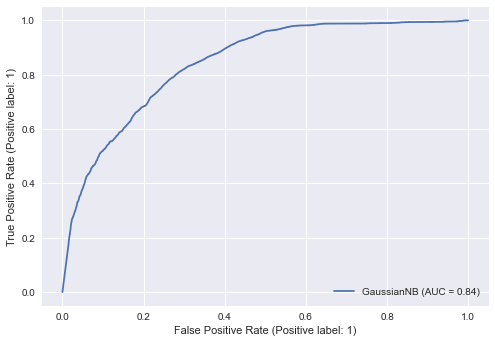

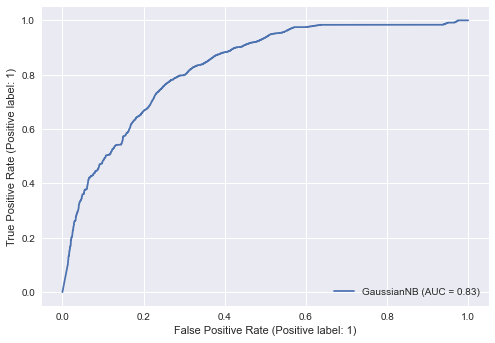

In [11]:
# prediction
model_log_scaled = GaussianNB()
model_log_scaled.fit(X_train_log_scaled, y_train)
y_train_pred = model_log_scaled.predict(X_train_log_scaled)
y_test_pred = model_log_scaled.predict(X_test_log_scaled)

# evaluations
show_metrics(y_train, y_train_pred, y_test, y_test_pred)

ras = roc_auc_score(y_train, model_log_scaled.predict_proba(X_train_log_scaled)[:,1])
print(f'ROC AUC: {ras*100} %')

RocCurveDisplay.from_estimator(model_log_scaled, X_train_log_scaled, y_train)
RocCurveDisplay.from_estimator(model_log_scaled, X_test_log_scaled, y_test)

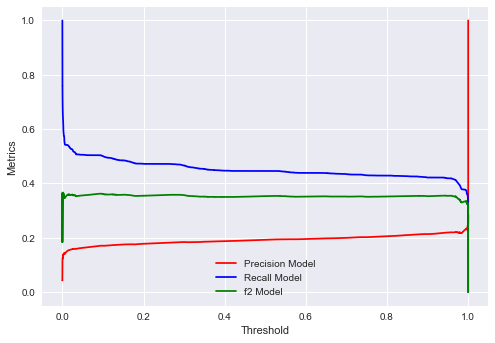

In [12]:
y_proba = model_log_scaled.predict_proba(X_test_log_scaled)[:,1]

pre, rec, thresholds = precision_recall_curve(y_test, y_proba)
f2 = (5)*(pre*rec)/(4*pre + rec)

plt.plot(thresholds, pre[1:],'r-',label = 'Precision Model')
plt.plot(thresholds, rec[1:],'b-',label = 'Recall Model')
plt.plot(thresholds, f2[1:],'g-',label = 'f2 Model')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.show()

# Log

    use all raw smart and smart999
    =======================================
    # For train data:
      f2-score  : 37.69595509967098 %
      precision : 18.095039018952065 %
      recall    : 51.69530887134231 %
      accuracy  : 88.6117557623793 %
    =======================================
    # For test data:
      f2-score  : 35.347534583722314 %
      precision : 19.65086105213494 %
      recall    : 44.16755037115588 %
      accuracy  : 90.02204146480638 %
    ROC AUC: 84.18953114684726 %


# For train data:
  f2-score  : 37.76670523990322 %
  precision : 17.836897852255017 %
  recall    : 52.40528166677726 %
  accuracy  : 88.34167141790266 %
# For test data:
  f2-score  : 35.33932471023014 %
  precision : 19.291609353507567 %
  recall    : 44.61823966065748 %
  accuracy  : 89.78484397551942 %
ROC AUC: 84.34185786380768 %


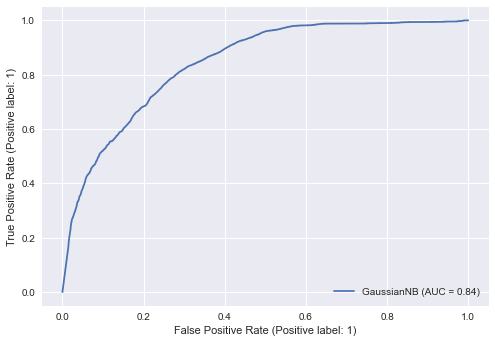

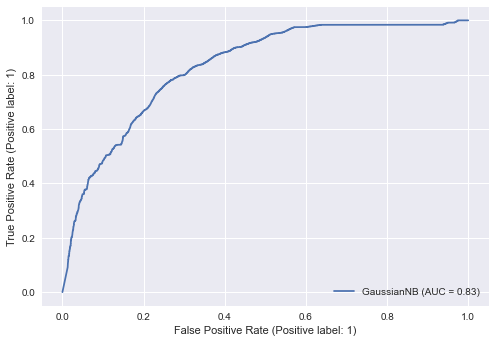

In [13]:
# prediction
model_log = GaussianNB()
model_log.fit(X_train_log, y_train)
y_train_pred = model_log.predict(X_train_log)
y_test_pred = model_log.predict(X_test_log)

# evaluations
show_metrics(y_train, y_train_pred, y_test, y_test_pred)

ras = roc_auc_score(y_train, model_log.predict_proba(X_train_log)[:,1])
print(f'ROC AUC: {ras*100} %')

RocCurveDisplay.from_estimator(model_log, X_train_log, y_train)
RocCurveDisplay.from_estimator(model_log, X_test_log, y_test)


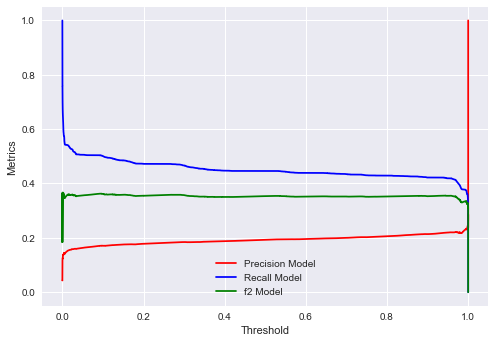

In [14]:
y_proba = model_log.predict_proba(X_test_log)[:,1]

pre, rec, thresholds = precision_recall_curve(y_test, y_proba)
f2 = (5)*(pre*rec)/(4*pre + rec)

plt.plot(thresholds, pre[1:],'r-',label = 'Precision Model')
plt.plot(thresholds, rec[1:],'b-',label = 'Recall Model')
plt.plot(thresholds, f2[1:],'g-',label = 'f2 Model')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.show()

In [16]:
df_train.smart_7_mod

0         1.208037e+09
2         1.638586e+09
3         1.615135e+09
4         1.586665e+09
5         1.716256e+09
              ...     
462959    1.582269e+09
462960    1.278042e+09
462961    1.481866e+09
462962    1.140796e+09
462963    1.586655e+09
Name: smart_7_mod, Length: 373587, dtype: float64

<AxesSubplot:xlabel='countdown', ylabel='smart_7_mod'>

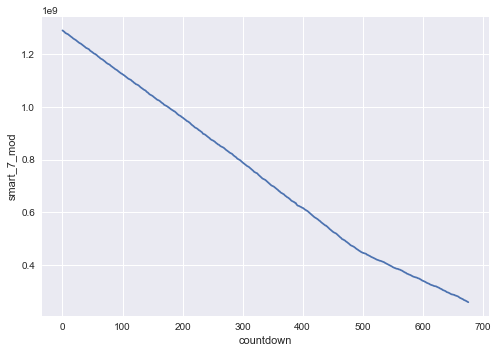

In [17]:
serial = 'Z304JG86'
sns.lineplot(data=df_train.query('serial_number == @serial'), x='countdown', y="smart_7_mod")

Index(['date', 'serial_number', 'model', 'failure', 'smart_1_normalized',
       'smart_1_raw', 'smart_3_normalized', 'smart_4_raw',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_7_raw', 'smart_9_normalized', 'smart_9_raw', 'smart_12_raw',
       'smart_183_normalized', 'smart_183_raw', 'smart_184_normalized',
       'smart_184_raw', 'smart_187_normalized', 'smart_187_raw',
       'smart_188_normalized', 'smart_188_raw', 'smart_189_normalized',
       'smart_189_raw', 'smart_190_normalized', 'smart_190_raw',
       'smart_192_raw', 'smart_193_normalized', 'smart_193_raw',
       'smart_194_normalized', 'smart_194_raw', 'smart_197_normalized',
       'smart_197_raw', 'smart_198_normalized', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown'],
      dtype='object')